
<img src="https://raw.githubusercontent.com/archivesunleashed/archivesunleashed.org/master/themes/hugo-material-docs/static/images/logo-square.png" height="100px" width="100px">


# Welcome

Welcome to the Archives Unleashed Cloud Visualization Demo in Jupyter Notebook for your collection. This demonstration takes the main derivatives from the Cloud and uses Python to analyze and produce information about your collection.

This product is in beta, so if you encounter any issues, please post an [issue in our Github repository](https://github.com/archivesunleashed/auk/issues) to let us know about any bugs you encountered or features you would like to see included.

If you have some basic Python coding experience, you can change the code we provided to suit your own needs.

Unfortunately, we cannot support code that you produced yourself. We recommend that you use `File > Make a Copy` first before changing the code in the repository. That way, you can always return to the basic visualizations we have offered here. Of course, you can also just re-download the Jupyter Notebook file from your Archives Unleashed Cloud account.

### How Jupyter Notebooks Work:

If you have no previous experience of Jupyter Notebooks, the most important thing to understand is that that <Shift><Enter/Return> will run the python code inside a window and output it to the site.
    
The window titled `# RUN THIS FIRST` should be the first place you go. This will import all the libraries and set basic variables (e.g. where your derivative files are located) for the notebook. After that, everything else should be able to run on its own.

If you just want to see the results for your collection, use `Cell > Run All`.


In [40]:
# Required imports from sys

from collections import Counter
import logging

coll_id = "4465"
auk_fp = "./data/"
auk_full_text = auk_fp + coll_id + "-fulltext.txt"
auk_gephi = auk_fp + coll_id + "-gephi.gexf"
auk_graphml = auk_fp + coll_id + "-gephi.grapml"
auk_domains = auk_fp + coll_id + "-fullurls.txt"
auk_filtered_text = auk_fp + coll_id + "-filtered_text.zip"

In [41]:
def sanity_check():
    output = "This script will check if you have all required dependencies:\n\n"
    try:
        import matplotlib.pyplot
        output += "Matplotlib OK.\n"
    except ImportError:
        output += "ERROR MATPLOTLIB required: Matplotlib is required to show graph visualizations.\n"
        output += "                           Try `pip install -u matplotlib` to install.\n"
    try:
        import ggplot
        output += "GGplot OK.\n"
    except ImportError:
        output += "WARN GGPlot: GGplot will improve graph visualizations.\n"
        output += "                           Try `pip install -u ggplot` to install.\n"
    try:
        import numpy
        output += "Numpy OK.\n"
    except ImportError:
        output += "WARN NUMPY MISSING: You will not be able to use some math features.\n"
        output += "                    Try `pip install -u numpy` to install.\n"
    try:
        import pandas
        output += "Pandas OK.\n"
    except ImportError:
        output += "WARN PANDAS MISSING: This means you cannot access dataframes.\n"
        output += "                     Try `pip install -u pandas` to install.\n"
    try: 
        import nltk
        from nltk.tokenize import word_tokenize, sent_tokenize
        from nltk.draw.dispersion import dispersion_plot as dp
        nltk.download('vader_lexicon')
        output += "Nltk OK.\n"
    except ImportError:
        output += "WARN NLTK MISSING: This means you cannot do text analysis.\n"
        output += "                   Try `pip install -u nltk` to install.\n"
    try:
        open(auk_full_text)
        output += "Full text OK.\n"
    except NameError:
        output += "ERROR No File Variables: Looks like you forgot to run the first window.\n"
        output += "                         Use <SHIFT><RETURN/ENTER> on the first code window\n"
    except FileNotFoundError:
        output += "ERROR No File Access: Could not open the full-text file.\n"
        output += "                      Did you remember to include the downloads in the same folder?\n"
    try:
        open(auk_gephi)
        output += "Gephi OK.\n"
    except NameError:
        output += "ERROR No File Variables: Looks like you forgot to run the first window.\n"
        output += "                         Use <SHIFT><RETURN/ENTER> on the first code window\n"
    except FileNotFoundError:
        output += "ERROR No File Access: Could not open the gephi file.\n"
        output += "                      Did you remember to include the downloads in the same folder?\n"
    try:
        open(auk_domains)
        output += "Domains OK.\n"
    except NameError:
        output += "ERROR No File Variables: Looks like you forgot to run the first window.\n"
        output += "                         Use <SHIFT><RETURN/ENTER> on the first code window\n"
    except FileNotFoundError:
        output += "ERROR No File Access: Could not open the domains file.\n"
        output += "                      Did you remember to include the downloads in the same folder?\n"
    return (output)

print(sanity_check())
    
    

This script will check if you have all required dependencies:

Matplotlib OK.
GGplot OK.
Numpy OK.
Pandas OK.
Nltk OK.
Full text OK.
ERROR No File Access: Could not open the gephi file.
                      Did you remember to include the downloads in the same folder?
Domains OK.



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ryandeschamps/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Text Analysis

The following set of functions use the [Natural Language Toolkit](https://www.nltk.org) Python library to search for the top most used words in the collection, as well as facilitate breaking it down by name or domain.

Set the variables below if you wish to make some changes.

In [151]:
##  CONSTANTS / CONFIGURATION
#
# If you wish to fine tune the outputs, you may change the following:
#
# maximum number of words to show in output.
# Jupyter will create an output error if the number is too high.
TOP_COUNT = 30 

# Domain suffixes to check non-U.S. domains.
# so that (e.g.) www.google.co.uk will become "google"
STOP_DOMAINS = ["co", "org", "net", "edu"] # domain suffixes to remove

# minimum number of characters for a word to be included in a corpus
MINIMUM_WORD_LENGTH = 3 # eliminates "it", "I", "be" etc.

# list of substrings to filter a text line, if desired
LINE_FILTER = ['404 Not Found', '403 Forbidden', '404 Document', '500 Internal Server', '503 Service', '301 Moved',
              '502 Proxy Error']

# Limit of results - large derivatives may cause your browser to freeze.
RESULTS_LIMIT = 2500


## Toolkit imports
import matplotlib.pyplot as pp
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.draw.dispersion import dispersion_plot as dp
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

def clean_domain(s):
    """Extracts the name from the domain (e.g. 'www.google.com' becomes 'google')."""
    ret = ""
    dom = s.split(".")
    if len(dom) <3: # x.com is always x
        ret = dom[0]
    elif dom[-2] in STOP_DOMAINS: # www.x.co.uk should be x
        ret = dom[-3]
    else:
        ret = dom[1]
    return ret


def get_text(by="all", minline=MINIMUM_WORD_LENGTH):
    """Get just the text from the files."""
    text = []
    with open(auk_full_text) as fin:
        head = [next(fin) for x in range(RESULTS_LIMIT)]
    for line in head:          
        split_line = str(line).split(",", 3)
        if (len(split_line[3]) >= 3 and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):   
            if by == "domain":    
                text.append((clean_domain(split_line[1]), split_line[3]))
            elif by == "year":
                text.append((split_line[0][1:5], split_line[3]))
            else:
                text.append(split_line[3])
    return text

def get_text_tokens (minlen=MINIMUM_WORD_LENGTH) :
    """Get the data and tokenize the text."""
    tokens = []
    with open (auk_full_text) as fin:
        head = [next(fin) for x in range(RESULTS_LIMIT)]
    for line in head:
        split_line = str(line).lower().split(",", 3)
        # remove lines that are smaller than 3 chars or in the FILTER list.
        if (len(split_line[3]) >= minlen and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):
            tokens += word_tokenize(split_line[3])
    tokens = [x for x in tokens if len(x) > minlen]
    return tokens

def get_tokens_domains(minlen=MINIMUM_WORD_LENGTH):
    """Get tokens by domain"""
    tokens = []
    with open (auk_full_text) as fin:
        head = [next(fin) for x in range(RESULTS_LIMIT)]
    for line in head:
        split_line = str(line).lower().split(",", 3)
        if (len(split_line[3]) >= minlen and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):
            tokens.append((clean_domain(split_line[1]), Counter([x for x in word_tokenize(str(split_line[3])) if len(x) > minlen])))
    return tokens

def get_tokens_years(minlen=MINIMUM_WORD_LENGTH):
    """Get tokens by year."""
    tokens = []
    with open (auk_full_text) as fin:
        head = [next(fin) for x in range(RESULTS_LIMIT)]
    for line in head:
        split_line = str(line).lower().split(",", 3)
        if (len(split_line[3]) >= minlen and set([split_line[3].find(x) for x in LINE_FILTER]) == {-1}):
            tokens.append((split_line[0][1:5], Counter([x for x in word_tokenize(str(split_line[3])) if len(x) > minlen])))
    return tokens

def year(minlen=MINIMUM_WORD_LENGTH):
    """Used by get_top_tokens_by to get the tokens by year."""
    return get_tokens_years(minlen)

def domain(minlen=MINIMUM_WORD_LENGTH):
    """Used by get_top_tokens_by to get tokens by domain."""
    return get_tokens_domains(minlen)
 
def get_top_tokens(total=TOP_COUNT, minlen=MINIMUM_WORD_LENGTH):
    """Return the top tokens for the text."""
    return [(key, value) for key, value in Counter(get_text_tokens(minlen)).most_common(total)]

def get_top_tokens_by(fun, total=TOP_COUNT, minlen=MINIMUM_WORD_LENGTH):
    """ Get the top tokens by a function.
    
    Parameters
    ----------
    fun: A function that returns a list of (key, Counter([tokenized_list]))
    total: The number of top tokens to return for each key.
    minlen: The minimum word length.
    
    Returns
    -------
    ret: list of minlen tokens by fun.
    """
    
    sep = dict()
    tokens = fun(minlen)
    sep = {k[0]: Counter() for k in tokens}
    for key, value in tokens:
        sep[key] += value
    ret = [(key, val.most_common(total)) for key, val in sep.items()]
    return (ret)

# applies utf-16 encoding to text, if possible
def international(text):
    unicode = text.encode("utf-8")
    try:
        ret = unicode.decode("UTF-32-LE")
    except UnicodeDecodeError:
        try:
            ret = unicode.decode("UTF-32-BE")
        except UnicodeDecodeError:
            try: 
                ret = unicode.decode("UTF-16-LE")
            except UnicodeDecodeError:
                try: 
                    ret = unicode.decode("UTF-16-BE")
                except UnicodeDecodeError:
                    logging.warning("Could not convert text to UTF-16 or UTF-32. Restoring UTF-8")
                    ret = unicode.decode("UTF-8")
            
    return ret

# writes results to stdout
def write_output (stdout, results):
    try:
        with open(filename, "w") as output:
            for value in results:
                output_file_write(str(value))
    except:
        print("Error writing the file.")
        
def sentiment_scores(by="domain"):
    sep = dict()
    corpus = get_text(by)
    sep = {k[0]: [] for k in corpus}
    for key, value in corpus:
        sep[key] += sent_tokenize(value)
    sid = SentimentIntensityAnalyzer()
    result = []
    for a, b in sep.items():
        scores = Counter({"neg": 0, "pos":0, "neu":0, "compound":0})
        for c in b:
            scores.update(sid.polarity_scores(c))
        result += [(a, ("neg", scores['neg']/len(b)), ("pos", scores['neg']/len(b)), ("neu", scores['neu']/len(b)), ("compound", scores['compound']/len(b)))]
      #  [(key, sid.polarity_scores(text)) for key, text in sep.items()]
    return(result)

Now that you have saved the above functions, you can now use them in a variety of ways. 

### Text by Year

In [152]:
method = "year" # choose "year", "domain" or "all"

# Get the set of available years in the collection 
year_range = set([x[0] for x in get_text(method)])
print(year_range)

{'2014', '2015'}


Now we can create separate lists with text files from individual years in this collection. You can add years (e.g. "2019") to `filtered_range` to limit your results.

In [153]:
# change if you want a different filename.
OUTPUT_FILENAME = "./filtered_text.txt" # filename if you want to output to another file.

# The years to include in the analysis. If empty, you will get all available years.
FILTERED_YEARS = [] # e.g. ['2015', '2016', '2019']

year_filter = FILTERED_YEARS if FILTERED_YEARS else year_range # add or remove years for filter
year_results = [t[1] for t in get_text("year") if t[0] in list(year_filter)]
    
# Some of the text may be in an international font.
for i in year_results[:10]:
    print(i)

## Commenting out the following will write the results to a `output_filename

#write_output(output_filename, year_results)

HTTP/1.1 200 OK Date: Fri, 21 Mar 2014 18:44:42 GMT Server: Apache X-Powered-By: PHP/5.3.28 P3P: CP="NOI ADM DEV PSAi COM NAV OUR OTRo STP IND DEM" Expires: Mon, 1 Jan 2001 00:00:00 GMT Cache-Control: no-store, no-cache, must-revalidate, post-check=0, pre-check=0 Pragma: no-cache Set-Cookie: 684cd27e6e3424024e28fbf325da9a22=n8dgjp0f9es4j6f1gtbc6vms52; path=/; HttpOnly Last-Modified: Fri, 21 Mar 2014 18:44:43 GMT Content-Length: 47316 Connection: close Content-Type: text/html; charset=utf-8 Home Home I want to... Read the Latest News Garden for Wildlife Protect my Land Get Kids Outside Care for Endangered Species About Western Painted Turtles About Sharp-tailed Snakes About Blue-grey Taildroppers Volunteer Donate ProgramsBlog & Current Projects STEWARDSHIP Good Neighbours Species at Risk Forest & Land Cover Mapping LAND PROTECTION Covenants & Acquisitions EDUCATION Green Spots Goldstream Chums Conservation Connection Forum Publications& Research & Data About HAT Who are we? Our Board Ou

### Text by Domain

In [154]:
# Get the set of available domains in the collection 
domain_set = set([x[0] for x in get_text("domain")])
print(domain_set)

{'youtube-nocookie', 'facebook', 'bc', 'pacificwild', 'cbc', 'youtube', 'vimeo', 'verticalresponse', 'bing', 'hat', 'globalnews', 'wordpress'}


In [155]:
# extract only the given domain to a file and see how many results there are
filtered_domains = [] # e.g ["google", "apple", "facebook"]
domain_set = filtered_domains if filtered_domains else domain_set
domain_results = [t[1] for t in get_text("domain") if t[0] in domain_set]
print("****Total files****:" + str(len(domain_results)) + "\n")
print("****Sample results****: \n")
for samp in domain_results[:10]:
    if len(samp) > 4:
        print(international(samp) + " \n")

****Total files****:2180

****Sample results****: 

呈偔ㄯㄮ㈠〰传⁋慄整›牆Ⱪ㈠‱慍⁲〲㐱ㄠ㨸㐴㐺′䵇⁔敓癲牥›灁捡敨堠倭睯牥摥䈭㩹倠偈㔯㌮㈮‸㍐㩐䌠㵐丢䥏䄠䵄䐠噅倠䅓⁩佃⁍䅎⁖問⁒呏潒匠偔䤠䑎䐠䵅•硅楰敲㩳䴠湯‬‱慊⁮〲㄰〠㨰〰〺‰䵇⁔慃档ⵥ潃瑮潲㩬渠ⵯ瑳牯ⱥ渠ⵯ慣档ⱥ洠獵⵴敲慶楬慤整‬潰瑳挭敨正〽‬牰ⵥ档捥㵫‰牐条慭›潮挭捡敨匠瑥䌭潯楫㩥㘠㐸摣㜲㙥㍥㈴〴㐲㉥昸晢㈳搵㥡㉡㴲㡮杤灪昰改㑳㙪ㅦ瑧换瘶獭㈵※慰桴⼽※瑈灴湏祬䰠獡⵴潍楤楦摥›牆Ⱪ㈠‱慍⁲〲㐱ㄠ㨸㐴㐺″䵇⁔潃瑮湥⵴敌杮桴›㜴ㄳ‶潃湮捥楴湯›汣獯⁥潃瑮湥⵴祔数›整瑸栯浴㭬挠慨獲瑥甽晴㠭䠠浯⁥潈敭䤠眠湡⁴潴⸮‮敒摡琠敨䰠瑡獥⁴敎獷䜠牡敤⁮潦⁲楗摬楬敦倠潲整瑣洠⁹慌摮䜠瑥䬠摩⁳畏獴摩⁥慃敲映牯䔠摮湡敧敲⁤灓捥敩⁳扁畯⁴敗瑳牥⁮慐湩整⁤畔瑲敬⁳扁畯⁴桓牡⵰慴汩摥匠慮敫⁳扁畯⁴求敵札敲⁹慔汩牤灯数獲嘠汯湵整牥䐠湯瑡⁥牐杯慲獭求杯☠䌠牵敲瑮倠潲敪瑣⁳呓坅剁卄䥈⁐潇摯丠楥桧潢牵⁳灓捥敩⁳瑡删獩⁫潆敲瑳☠䰠湡⁤潃敶⁲慍灰湩⁧䅌䑎倠佒䕔呃佉⁎潃敶慮瑮⁳…捁畱獩瑩潩獮䔠啄䅃䥔乏䜠敲湥匠潰獴䜠汯獤牴慥⁭桃浵⁳潃獮牥慶楴湯䌠湯敮瑣潩⁮潆畲⁭畐汢捩瑡潩獮…敒敳牡档☠䐠瑡⁡扁畯⁴䅈⁔桗⁯牡⁥敷‿畏⁲潂牡⁤畏⁲瑓晡⁦敂潣敭愠䴠浥敢⁲潃瑮捡⁴獵䐠湯瑡⁥潄慮整丠睯䴠歡⁥⁡汐湡敮⁤楇瑦䤠獮楰敲夠畯獲汥Ⅶ䨠楯⁮獵䴠祡㐠桴映牯漠牵氠牡敧瑳攠敶⁲慎楴敶倠慬瑮䜠牡敤⁮潴牵⸠⸮删慥⁤潍敲倠潲整瑣摥›祔䴠湹摹⁤敎汷⁹牰瑯捥整⁤慨楢慴⁴湩䴠瑥档獯湩挠浯汰浥湥獴攠楸瑳湩⁧慰歲删慥⁤潍敲䴠歡⁥畔瑲敬䠠浯獥›慂歳湩⁧潬獧朠⁯湩潴匠慷⁮慌敫删慥⁤潍敲몀릀ㄠ㈠㌠吠敨敳瘠摩潥⁳楨桧楬桧⁴潨⁷潹⁵慣⁮敨灬丠瑡癩⁥汐湡⁴慇摲湥吠畯⁲潇摯祢⁥湡⁤效汬⁯桔湡獫琠⁯桓睡吠❖⁳䐢摩夠畯䬠潮≷猠来浥湥ⱴ䠠呁挠湡猠慨敲猠浯⁥牧慥⁴畱捩⁫楶敤獯愠潢瑵漠牵眠牯⁫湡⁤潨⁷潹⁵慣⁮敢椠癮汯敶⹤䘠物瑳甠⁰獩愠瘠摩潥愠潢瑵漠牵䌠瑩穩湥匠楣湥散瀠潲敪瑣ⱳ椠⁮慰瑲捩汵牡琠敨䈠畬ⵥ牧祥吠楡摬潲灰牥匠畬⹧䔠敶祲湯⁥慣⁮慰瑲捩慰整椠⁮捳敩据Ⅵ删慥⁤潍敲䨠楯⁮獵映牯漠牵愠湮慵⁬慎楴敶倠慬瑮䜠牡敤⁮潔牵漠⁮畓摮祡愠瑦牥潮湯‬慍⁹琴⹨䘠牯礠畯⁲潣祰漠⁦桴⁥潴牵朠極敤攠慭汩吠楨⁳浥楡⁬摡牤獥⁳獩戠楥杮瀠潲整瑣摥映潲⁭灳浡潢獴‮潙⁵敮摥䨠癡卡牣灩⁴湥扡敬⁤潴瘠敩

## Overall Collection Characteristics

In [156]:
# Get a list of the top words in the collection
# (regardless of year).
get_top_tokens()

[('this', 8637),
 ('ecological', 7828),
 ('species', 7335),
 ('park', 7303),
 ('2011', 7009),
 ('march', 6948),
 ('about', 6936),
 ('2013', 6289),
 ('uplands', 6057),
 ('friends', 5908),
 ('from', 5531),
 ('your', 5510),
 ('with', 5176),
 ('reserves', 4804),
 ('2014', 4718),
 ('research', 4663),
 ('email', 4630),
 ('warden', 4444),
 ('that', 4377),
 ('april', 4323),
 ('reserve', 4278),
 ('2015', 4277),
 ('june', 4148),
 ('land', 4019),
 ('2012', 3874),
 ('garry', 3853),
 ('ecoreserves', 3668),
 ('donate', 3572),
 ('board', 3533),
 ('connection', 3527)]

In [157]:
# Get a list of the top tokens, separated by year.
get_top_tokens_by(year)[0:10]

[('2014',
  [('about', 4054),
   ('your', 3619),
   ('land', 3612),
   ('this', 3049),
   ('email', 2599),
   ('with', 2542),
   ('address', 2462),
   ('species', 2451),
   ('donate', 2387),
   ('more', 2287),
   ('native', 2185),
   ('garden', 2134),
   ('read', 2091),
   ('from', 2005),
   ('that', 1982),
   ('conservation', 1871),
   ('connection', 1847),
   ('protected', 1629),
   ('care', 1547),
   ('contact', 1518),
   ('no-cache', 1487),
   ('2014', 1462),
   ('endangered', 1444),
   ('protect', 1415),
   ('will', 1406),
   ('need', 1375),
   ('plant', 1349),
   ('volunteer', 1296),
   ('home', 1284),
   ('blue-grey', 1282)]),
 ('2015',
  [('ecological', 7739),
   ('march', 6879),
   ('2011', 6801),
   ('park', 6651),
   ('2013', 6188),
   ('uplands', 6051),
   ('friends', 5633),
   ('this', 5588),
   ('species', 4884),
   ('reserves', 4792),
   ('warden', 4444),
   ('2015', 4277),
   ('april', 4265),
   ('reserve', 4237),
   ('june', 4094),
   ('research', 3842),
   ('2012', 37

In [158]:
# Get a list of top tokens, separated by domain.
get_top_tokens_by(domain)[0:10]

[('hat',
  [('about', 3965),
   ('land', 3574),
   ('your', 3494),
   ('this', 2912),
   ('email', 2567),
   ('address', 2441),
   ('with', 2426),
   ('species', 2423),
   ('donate', 2367),
   ('more', 2214),
   ('native', 2147),
   ('garden', 2103),
   ('read', 2079),
   ('from', 1971),
   ('that', 1953),
   ('conservation', 1856),
   ('connection', 1821),
   ('protected', 1618),
   ('care', 1530),
   ('contact', 1501),
   ('endangered', 1428),
   ('no-cache', 1424),
   ('protect', 1403),
   ('2014', 1391),
   ('will', 1380),
   ('need', 1363),
   ('plant', 1332),
   ('volunteer', 1273),
   ('home', 1268),
   ('blue-grey', 1268)]),
 ('youtube',
  [('views', 342),
   ('loading', 248),
   ('sign', 221),
   ('youtube', 150),
   ('video', 109),
   ('this', 100),
   ('shawtvsouthvi', 80),
   ('your', 76),
   ('with', 71),
   ('victoria', 56),
   ('google', 51),
   ('account', 51),
   ('google+', 51),
   ('gmail', 51),
   ('orkut', 51),
   ('picasa', 51),
   ('chrome', 51),
   ('later', 51)

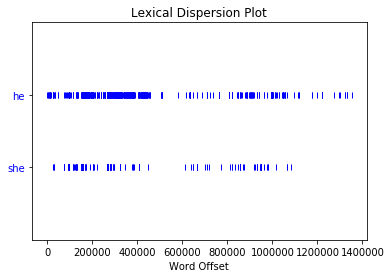

In [162]:
# Create a dispersion plot, showing where the list of words appear
# in the text.
text = get_text_tokens(1)
dp(text, ["he", "she"]) # uses the nltk dispersion plot library (dp).

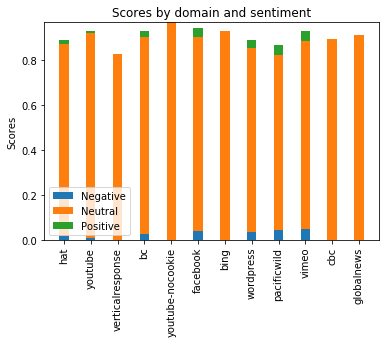

In [160]:
# Collect sentiment scores by domain and visualize them.

sent = sentiment_scores()
N = len(sent)
neg = [x[1][1] for x in sent]
pos = [x[2][1] for x in sent]
neu = [x[3][1] for x in sent]
labs = [x[0] for x in sent]

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = pp.bar(ind, neg, width)
p2 = pp.bar(ind, neu, width,
             bottom=neg)
p3 = pp.bar(ind, pos, width, bottom=neu)

pp.ylabel('Scores')
pp.title('Scores by domain and sentiment')
pp.xticks(ind, labs, rotation='vertical')
pp.legend((p1[0], p2[0], p3[0]), ('Negative', 'Neutral', 'Positive'))

pp.show()


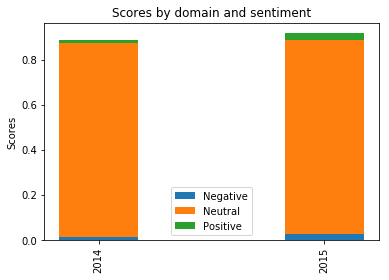

In [161]:
# Collect sentiment scores by year and visualize them.

sent = sentiment_scores("year")
N = len(sent)
neg = [x[1][1] for x in sent]
pos = [x[2][1] for x in sent]
neu = [x[3][1] for x in sent]
labs = sorted([x[0] for x in sent])

ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = pp.bar(ind, neg, width)
p2 = pp.bar(ind, neu, width,
             bottom=neg)
p3 = pp.bar(ind, pos, width, bottom=neu)

pp.ylabel('Scores')
pp.title('Scores by domain and sentiment')
pp.xticks(ind, labs, rotation='vertical')
pp.legend((p1[0], p2[0], p3[0]), ('Negative', 'Neutral', 'Positive'))

pp.show()

# Bibliography

Bird, Steven, Edward Loper and Ewan Klein (2009), *Natural Language       Processing with Python*. O’Reilly Media Inc.

Archives Unleashed Project. (2018). Archives Unleashed Toolkit (Version 0.17.0). Apache License, Version 2.0.